# Coronavirus Cases in Finland

__Bernardo Di Chiara__

_Last update: March 14<sup>th</sup>, 2020_

## Table of Contents

[1. Overview](#1.)<br>
[2. Setup](#2.)<br>
[3. Defining the Needed Functions](#3.)<br>
<font color='white'>....</font>[3.1. Dataframes and lists handling](#3.1.)<br>
<font color='white'>....</font>[3.2. Scatter and line plots](#3.2.)<br>
[4. Dumping the Data](#4.)<br>
[5. Data Analysis](#5.)<br>
<font color='white'>....</font>[5.1. Summary](#5.1.)<br>
<font color='white'>....</font>[5.2. Preliminary Data Analysis](#5.2.)<br>
<font color='white'>....</font>[5.3. Data Preparation](#5.3.)<br>
<font color='white'>....</font>[5.4. Data Visualization](#5.4.)<br>
[6. Conclusions](#6.)<br>

## 1. Overview <a name="1."></a>

This notebook contains visualizations realated to the spread of Coronavirus in Finland.

The data is taken from the [Johns Hokpins University](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/data) (JHU) /1/ and from [this page](https://finland-coronavirus-map.netlify.com/) /2/ for the last day updates.

There are a lot of pages related to this topic in the Web but currently there is no free site that shows the daily cases in Finland with a delay of less that 24 hours.

Having updated charts is very useful both for authorities and population in order to make fact-based decisions that help to contain the cases and minimize the casualities.

<sub>/1/<br>
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/data</sub>

<sub>/2/<br>
https://finland-coronavirus-map.netlify.com/</sub>

**If you are not interested to the code, go to section 5.4. through the link in the table of contents and focus only on the charts.**

## 2. Setup <a name="2."></a>

In [1]:
# Importing the needed packages
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying all the dafaframe columns
pd.set_option('display.max_columns', None)

## 3. Defining the Needed Functions <a name="3."></a>

### 3.1. Dataframe handling<a name="3.1."></a>

In [2]:
def df_basic_data(dfname):
    '''
    This function prints basic information about a given dataframe.
    The function needs as input parameters the dataframe name.
    '''

    import pandas as pd

    # Fetching the dataframe name
    name = [x for x in globals() if globals()[x] is dfname][0]
    print("Dataframe name:", name, "\n")
    print("Dataframe length:", len(dfname), "\n")
    print("Number of columns:", len(dfname.columns), "\n")
    # Columns data types
    data_types = dfname.dtypes
    # Distint values
    distint_values = dfname.apply(pd.Series.nunique)
    # Amount of null values
    null_values = dfname.isnull().sum()
    print("Dataframe's columns names, column data types, amount of distint "
          "(non null) values\n"
          "and amount of null values for each column:")
    df_index = ['Data_Type',
                'Amount_of_Distint_Values',
                'Amount_of_Null_Values']
    col_types_dist_null = pd.DataFrame([data_types,
                                        distint_values,
                                        null_values],
                                       index=df_index)
    return col_types_dist_null.transpose()

In [76]:
def calc_increments(listname):
    '''
    This function:
    takes a list,
    calculates the delta between each element and its predecessor,
    returns the result in a new list having the same lenght as the original list
    '''

    # Initializing an empty list of floats to contain the increments
    increments = []
    # Adding zero to the first element
    increments.append(0.0)
    # Looping through all the occurrencies except the first one
    for i in list(range(1, len(listname))):
        # Calculating the increment
        delta = listname[i]-listname[i-1]
        # Adding the result to the list
        increments.append(delta)
    # Returning the result
    return increments

### 3.2. Scatter and line plots<a name="3.2."></a>

In [158]:
def cust_line_plot(*parameters, x,
                   figsize_w=8, figsize_h=6,
                   title=None, title_fs=16, title_offset=20,
                   rem_borders=False,
                   x_label=None, xlabel_fs=12,
                   xvalues_fs=6, rot=0,
                   y_label=None, ylabel_fs=12,
                   legend=False):
    """
    This function plots a scatterplot for the provided data
    and customizes the way the chart looks by using the value of
    the provided parameters.

    Keyword arguments:
    parameters       -- A tuple of 3 elements containing:
                        a list with the y values,
                        an integer (from 0 to 9) selecting the seaborn-deep
                        color,
                        a string containing the text for the legend
                        (mandatory)
    x                -- A list Series containing the x values (mandatory)
    figsize_w        -- The width of the plot area
    figsize_w        -- The height of the plot area
    title            -- A string containing the title of the chart
    title_fs         -- The title font size
    title_offset     -- Distance between the title and the top of the chart
    rem_borders      -- If True the top and right borders are removed
                        (default: False)
    x_label          -- Label for the x-axis (string)
    xlabel_fs        -- x axis labels' font size
    xvalues_fs       -- The tick values font size
    rot              -- The rotation angle of the tick values
    y_label          -- Label for the y-axis (string)
    ylabel_fs        -- y axis labels' font size
    legend           -- A boolean variable that tells if to plot a legend
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Creating a new figure
    plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')
    # Adding a title (with some distance to the top of the plot)
    plt.title(title, fontsize=title_fs, pad=title_offset)
    # Removing the top and right borders if so defined
    if rem_borders is True:
        sns.despine(top=True, right=True, left=False, bottom=False)

    # Initializing an empy list to contain the legend text
    leg_text_l = []
    for param in parameters:
        # Extracting the values given in parameters
        y = param[0]
        col_numb = param[1]
        leg_text = param[2]
        # Appending the string to the list
        leg_text_l.append(leg_text)
        # Creating the scatter plots
        plot = plt.plot(x, y, marker=".", color=color_list[col_numb])

    # If a label for the x axis is provided, showing it on the x axis
    if x_label:
        plt.xlabel(x_label, fontsize=xlabel_fs)
    plt.xticks(fontsize=xvalues_fs, rotation=rot)
    # If a label for the y axis is provided, showing it on the y axis
    if y_label:
        plt.ylabel(y_label, fontsize=ylabel_fs)

    # Adding a legend
    if legend:
        plt.legend(labels=leg_text_l)

    # Showing the plot without additional text
    plt.show()

## 4. Dumping the Data <a name="4."></a> 

The source csv files are located in the directory <code>latest_csv_files</code> under the directory containing this notebook.

In [4]:
# Loading the data files into pandas dataframes
# Loading the world time series
world_confirmed = pd.read_csv('latest_csv_files/time_series_covid_19_confirmed.csv')
world_recovered = pd.read_csv('latest_csv_files/time_series_covid_19_recovered.csv')
world_deaths = pd.read_csv('latest_csv_files/time_series_covid_19_deaths.csv')

In [5]:
# Loading other world related datasets
line_list = pd.read_csv('latest_csv_files/COVID19_line_list_data.csv')
open_line_list = pd.read_csv('latest_csv_files/COVID19_open_line_list.csv')
data = pd.read_csv('latest_csv_files/covid_19_data.csv')

**File descriptions**

- <code>time_series_covid_19_confirmed.csv</code>: confirmed cases for each day for each Country
- <code>time_series_covid_19_recovered.csv</code>: confirmed cases for each day for each Country
- <code>time_series_covid_19_deaths.csv</code>: confirmed cases for each day for each Country

the other 3 files have not been analyzed yet

## 5. Data Analysis <a name="5."></a>

### 5.1. Summary<a name="5.1."></a>

The 3 time series files have colums for Province/State, Country/Region, Latitude, Longitude and data for each day. The column related to the day is named in the format m/d/yy.

Each entry represents a different location.

Data about Finland has been extracted from the files produced by Johns Hopikns University.

Data related to days with non zero confirmed cases has been extracted.

Data related to the missing day has been added by using the information contained in the Finnish specific site.

A line plot containing conformed cases each day as well as recovered cases and deceased has been produced.

### 5.2. Preliminary Data Analysis<a name="5.2."></a>

In [6]:
# Showing basic dataframe info
df_basic_data(world_confirmed)

Dataframe name: world_confirmed 

Dataframe length: 404 

Number of columns: 54 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,249,121
Country/Region,object,132,0
Lat,float64,356,0
Long,float64,350,0
1/22/20,int64,11,0
1/23/20,int64,15,0
1/24/20,int64,19,0
1/25/20,int64,28,0
1/26/20,int64,29,0
1/27/20,int64,33,0


In [8]:
# Showing basic dataframe info
df_basic_data(world_recovered)

Dataframe name: world_recovered 

Dataframe length: 404 

Number of columns: 54 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,249,121
Country/Region,object,132,0
Lat,float64,356,0
Long,float64,350,0
1/22/20,int64,2,0
1/23/20,int64,3,0
1/24/20,int64,4,0
1/25/20,int64,4,0
1/26/20,int64,4,0
1/27/20,int64,6,0


In [7]:
# Showing basic dataframe info
df_basic_data(world_deaths)

Dataframe name: world_deaths 

Dataframe length: 404 

Number of columns: 54 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,249,121
Country/Region,object,132,0
Lat,float64,356,0
Long,float64,350,0
1/22/20,int64,2,0
1/23/20,int64,3,0
1/24/20,int64,3,0
1/25/20,int64,3,0
1/26/20,int64,3,0
1/27/20,int64,3,0


In [9]:
# Checking how data looks like
world_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990,990,990,990,990,NaN
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414,414,418,418,422,426,428,428,429,NaN
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,NaN
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296,296,296,296,296,296,296,296,296,NaN
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,102,119,120,124,124,125,0.0


In [11]:
# Checking how data looks like
world_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,Anhui,Mainland China,31.8257,117.2264,0,0,0,0,0,0,0,2,2,3,5,7,14,20,23,34,47,59,72,88,105,127,157,193,221,255,280,361,413,474,539,597,637,663,712,744,792,821,868,873,917,936,956,970,979,979,984,984,984,NaN
1,Beijing,Mainland China,40.1824,116.4142,0,0,1,2,2,2,4,4,4,5,9,9,12,23,24,31,33,34,37,44,48,56,69,80,98,108,114,122,145,153,169,178,189,198,215,235,248,257,271,276,282,288,297,297,299,303,308,315,320,NaN
2,Chongqing,Mainland China,30.0572,107.8740,0,0,0,0,0,0,0,1,1,1,3,7,9,9,15,24,31,39,51,66,79,102,128,152,184,207,225,254,274,299,316,328,335,349,372,384,401,422,438,450,469,490,502,512,513,526,527,542,547,NaN
3,Fujian,Mainland China,26.0789,117.9874,0,0,0,0,0,0,0,0,0,0,0,0,1,3,11,14,20,24,35,39,45,53,57,63,71,82,90,93,112,126,149,162,170,183,199,218,228,235,243,247,255,260,270,277,284,295,295,295,295,NaN
4,Gansu,Mainland China,36.0611,103.8343,0,0,0,0,0,0,0,0,0,0,0,3,3,4,6,6,9,12,16,17,24,31,39,39,49,54,58,62,65,71,76,76,78,80,80,81,81,82,82,84,85,86,87,87,87,87,87,88,88,0.0


In [10]:
# Checking how data looks like
world_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,Anhui,Mainland China,31.8257,117.2264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,4,4,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,NaN
1,Beijing,Mainland China,40.1824,116.4142,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,7,8,8,8,8,8,8,8,8,8,8,8,NaN
2,Chongqing,Mainland China,30.0572,107.8740,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,3,3,4,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,NaN
3,Fujian,Mainland China,26.0789,117.9874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NaN
4,Gansu,Mainland China,36.0611,103.8343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0.0


### 5.3. Data Preparation<a name="5.3."></a>

#### 5.3.1. Finnish data from JHU <a name="5.3.1."></a>

In [87]:
# Extracting data about confirmed cases in Finland
finland_confirmed = world_confirmed[world_confirmed['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values
finland_confirmed = finland_confirmed.iloc[:,9:]
# Extracting the column values (dates) and putting them in a list
days = finland_confirmed.columns.values.tolist()

# Initializing an empty list
days_short = []
# Looping through the number of days
for i in list(range(len(days))):
    # Extracting day and month and taking just the string value
    new_element=re.findall("[0-9]+[/][0-9]+", days[i])[0]
    # Adding the result to the list
    days_short.append(new_element)
    
days_short

['1/27',
 '1/28',
 '1/29',
 '1/30',
 '1/31',
 '2/1',
 '2/2',
 '2/3',
 '2/4',
 '2/5',
 '2/6',
 '2/7',
 '2/8',
 '2/9',
 '2/10',
 '2/11',
 '2/12',
 '2/13',
 '2/14',
 '2/15',
 '2/16',
 '2/17',
 '2/18',
 '2/19',
 '2/20',
 '2/21',
 '2/22',
 '2/23',
 '2/24',
 '2/25',
 '2/26',
 '2/27',
 '2/28',
 '2/29',
 '3/1',
 '3/2',
 '3/3',
 '3/4',
 '3/5',
 '3/6',
 '3/7',
 '3/8',
 '3/9',
 '3/10',
 '3/11']

In [88]:
# Creating an empty list of same lenght as days_short
dummy = []
for i in list(range(len(days_short))):
    dummy.append(0.0)

In [90]:
# Time series of confirmed cases in Finland
finland_confirmed = world_confirmed[world_confirmed['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values
finland_confirmed = finland_confirmed.iloc[:,9:]
# Copying the result into a list
finland_confirmed_l = finland_confirmed.values.tolist()[0]

finland_confirmed_l

[0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 6.0,
 6.0,
 6.0,
 6.0,
 12.0,
 15.0,
 15.0,
 23.0,
 30.0,
 40.0,
 59.0]

In [91]:
# Time series of recovered cases in Finland
finland_recovered = world_recovered[world_recovered['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values in the confirmed cases
finland_recovered = finland_recovered.iloc[:,9:]
# Copying the result into a list
finland_recovered_l = finland_recovered.values.tolist()[0]

finland_recovered_l

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [92]:
# Time series of deaths cases in Finland
finland_deaths = world_deaths[world_deaths['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values in the confirmed cases
finland_deaths = finland_deaths.iloc[:,9:]
# Copying the result into a list
finland_deaths_l = finland_deaths.values.tolist()[0]

finland_deaths_l

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

#### 5.3.2. Completing the time series with the latest infor from Finland <a name="5.3.2."></a>

In [93]:
# Adding last day info
# Add manually here the day and the related data
days_short.append('3/12')
finland_confirmed_l.append(155.0)
finland_recovered_l.append(2.0)
finland_deaths_l.append(0.0)
dummy.append(0.0)

In [94]:
# Adding last day info
# Add manually here the day and the related data
days_short.append('3/13')
finland_confirmed_l.append(223.0)
finland_recovered_l.append(2.0)
finland_deaths_l.append(0.0)
dummy.append(0.0)

In [165]:
# Adding last day info
# Add manually here the day and the related data
days_short.append('3/14')
finland_confirmed_l.append(225.0)
finland_recovered_l.append(10.0)
finland_deaths_l.append(0.0)
dummy.append(0.0)

#### 5.3.3. Calculating the increments <a name="5.3.3."></a>

In [166]:
# Creating a list of same lenght as days_short containing the increment of the confirmed cases
# compared to the previous day (first derivate)
# This tells how quickly the confirmed cases are growing
finland_conf_incr = calc_increments(finland_confirmed_l)

finland_conf_incr 

[0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 3.0,
 0.0,
 0.0,
 0.0,
 6.0,
 3.0,
 0.0,
 8.0,
 7.0,
 10.0,
 19.0,
 96.0,
 68.0,
 2.0]

### 5.4. Data Visualization<a name="5.4."></a>

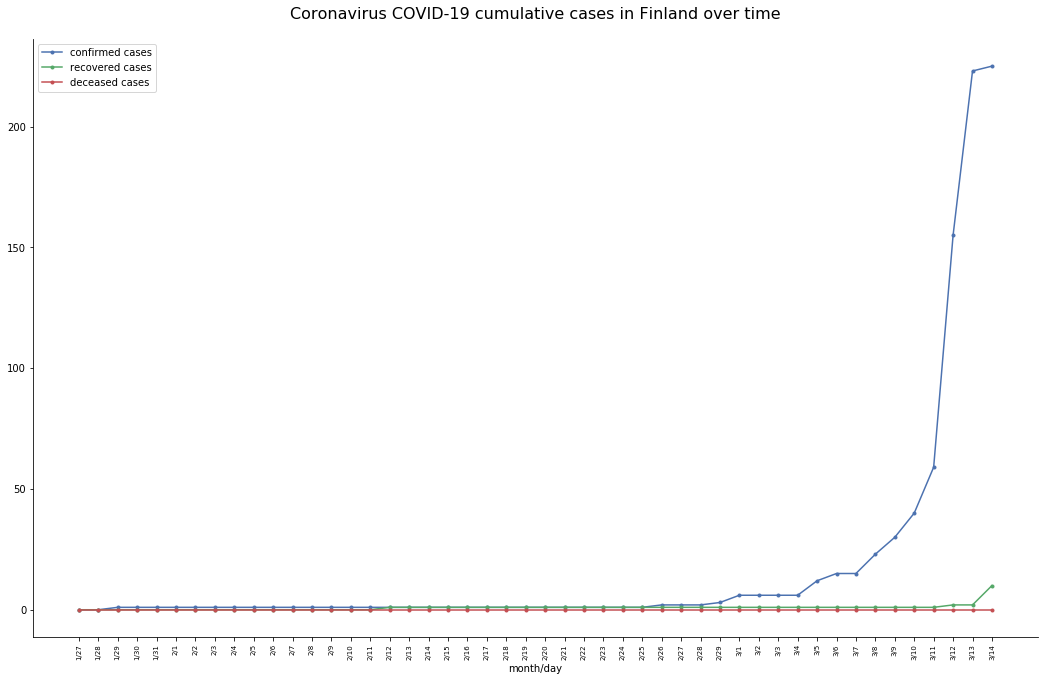

In [169]:
# Plotting daily cumulative cases in Finland
cust_line_plot((finland_confirmed_l, 0, "confirmed cases"),
               (finland_recovered_l, 2, "recovered cases"),
               (finland_deaths_l, 3, "deceased cases"),
               x=days_short,
               figsize_w=18, figsize_h=11,
               title="Coronavirus COVID-19 cumulative cases in Finland over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=10,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

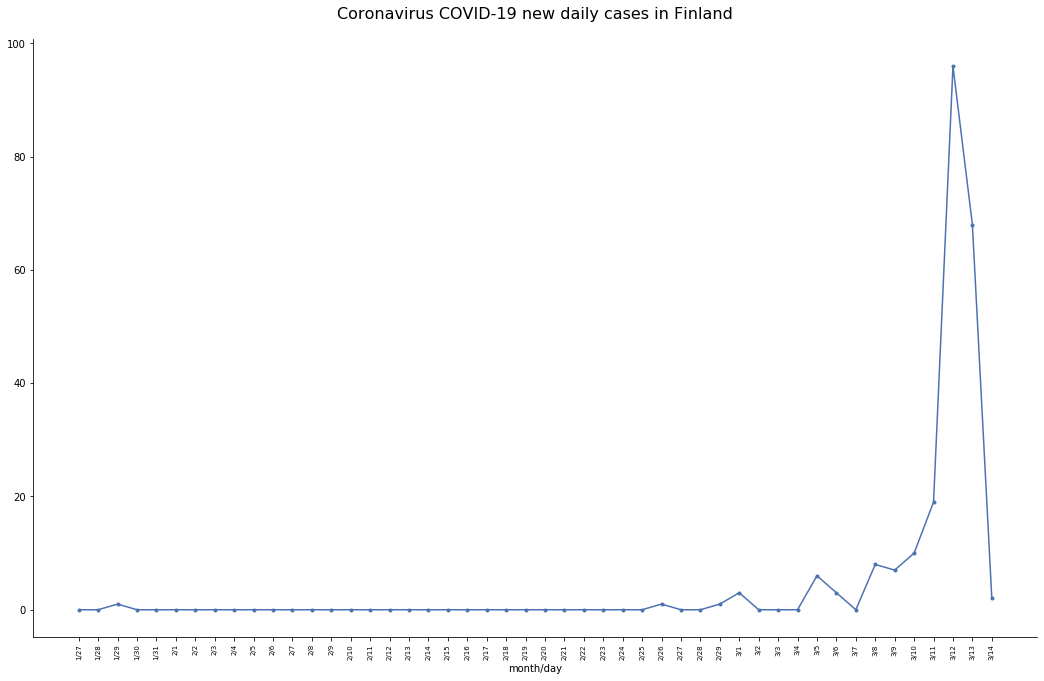

In [170]:
# Plotting new daily confirmed Coronavirus cases in Finland
cust_line_plot((finland_conf_incr, 0, ""),
               x=days_short,
               figsize_w=18, figsize_h=11,
               title="Coronavirus COVID-19 new daily cases in Finland",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=10,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=False)

## 6. Conclusions <a name="6."></a>

The plots are self explanatory. Due to the need of daily updates, no additional comment is added here.

---
<sub>Linux Ubuntu 18.04</sub><br>
<sub>Jupyter Notebook server 6.0.1</sub><br>
<sub>Python 3.6.8</sub><br>
<sub>numpy 1.17.3</sub><br>
<sub>pandas 0.25.2</sub><br>
<sub>matplotlib 3.1.2</sub><br>
<sub>seaborn 0.9.0</sub><br>
<sub>scikit-learn 0.21.3</sub><br>